In [212]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from tqdm import tqdm
from collections import deque
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [38]:
with open('telegram_df', 'rb') as file:
    telegram_df = pickle.load(file)
telegram_df['user_1_score'] = np.absolute(np.min(telegram_df['user_1_score'])) + telegram_df['user_1_score']

In [39]:
telegram_df

,text,user_1_score
0,🇷🇺🇺🇦⚡- ukraine has begun building three massiv...,14.196616
1,🇷🇺🇺🇦⚡- russian forces have entered yasnaya pol...,11.825826
2,"🇷🇺🇺🇦⚡- in the pokrovsk direction, russia captu...",16.111466
3,🫡🇷🇺🇺🇦 russian flags in selidovo and at the kor...,15.555278
4,💸📈❗️ — bitcoin ($btc) hits 71000 usd/coin!,5.766094
...,...,...
26764,ukrainian military commissars continue to hunt...,13.647940
26765,a mural in honor of terrorist budanov appeared...,10.187166
26766,a ukrainian militant sincerely does not unders...,8.112790
26767,powerful footage of a russian btr-82 fighting ...,10.064772


In [27]:
vectorizer = TfidfVectorizer(max_features = 1000)
tfidf_matrix = vectorizer.fit_transform(telegram_df['text']).toarray()

In [28]:
tfidf_tensors = torch.tensor(tfidf_matrix, dtype=torch.float32)

In [183]:
X = [idx for idx in range(len(tfidf_tensors))]
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_test, test_size=0.5, random_state=42)

In [184]:
tensor_dims = tfidf_tensors.size(1)

In [185]:
best_model = None

In [189]:
def ndcg(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)
    dcg = np.sum(relevance_scores[:k] / np.log2(np.arange(2, k + 2)))
    ideal_relevance_scores = np.sort(relevance_scores)[::-1]
    idcg = np.sum(ideal_relevance_scores[:k] / np.log2(np.arange(2, k + 2)))
    if idcg == 0:
        return 0.0 
    return dcg / idcg

In [199]:
def precision(evaluated_model_relevances, k):
    top_k = evaluated_model_relevances[:k]
    relevant_items = sum([1 for relevance in top_k if relevance == 1])
    precision_at_k = relevant_items / k
    return precision_at_k

In [195]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.5):
        super(QNetwork, self).__init__()
        self.lin_1 = nn.Linear(input_dim, input_dim // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob) 
        self.lin_2 = nn.Linear(input_dim // 2, 2)

    def forward(self, state):
        x = self.lin_1(state)
        x = self.relu(x)
        x = self.dropout(x) 
        x = self.lin_2(x)
        return x

class RankingAgent:
    def __init__(self, input_dim, learning_rate=0.001, gamma=0.99, epsilon=1, batch_size = 32, pretrained_model = None):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        if pretrained_model:
            self.model = QNetwork(input_dim).load_state_dict(pretrained_model)
        else:
            self.model = QNetwork(input_dim)
        self.target_model = QNetwork(input_dim)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.replay_memory_buffer = deque(maxlen=10000) 
          
    def reward_function(self, model_label, true_label):
        if model_label == true_label:
            return 100
        else:
            return -100
    
    def choose_action(self, current_state):
        q_scores = self.model(current_state)
        if np.random.rand() > self.epsilon:  
            action = torch.argmax(q_scores).item()
        else:  
            action = random.choice([0,1])
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        return action

    def eval(self, selected_post_embs, indices):
        q_scores = self.model(selected_post_embs).detach().numpy()
        actions = [np.argmax(q_scores[i]) for i in range(len(q_scores))]
        highest_q_scores = [np.max(q_scores[i]) for i in range(len(q_scores))]        
        sorted_posts = sorted(zip(indices, highest_q_scores, actions), key=lambda x: x[1], reverse=True)
        selected_posts = [post[0] for post in sorted_posts if post[2] == 1]
        return selected_posts, actions

    def update(self):
        if len(self.replay_memory_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_memory_buffer, self.batch_size)
        current_states, actions, rewards, next_states, dones = zip(*batch)
        
        next_states = torch.stack(next_states)
        current_states = torch.stack(current_states)
        dones = torch.tensor([int(bool) for bool in dones])
        
        actions = torch.tensor(actions)
        rewards = torch.tensor(rewards)
        q_values = self.model(current_states)
        q_values = q_values.gather(1, actions.unsqueeze(1))
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        with torch.no_grad():
            next_q_values = self.model(next_states).max(1, keepdim=True)[0]
            target_q_values = rewards + (1-dones)*self.gamma * next_q_values
        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

In [201]:
best_model = None

In [214]:
agent = RankingAgent(input_dim=tfidf_tensors.size(1))
step_counter = 0
TOP_N_POSTS = 10
NUM_EPISODES = 500
NUM_RANDOM_POSTS = 100
NUM_STEPS = 10
relevance_cutoff = np.mean(telegram_df['user_1_score']) + np.std(telegram_df['user_1_score'])
avg_rewards = []
train_accs = []
val_accs = []
train_precs = []
val_precs = []
ndcgs_train = []
ndcgs_val = []
train_recalls = []
val_recalls = []
best_val_recall = 0
for episode in range(NUM_EPISODES):
    episode_rewards = []
    for step in range(200):
        done = False
        random_posts = random.sample(X_train, NUM_RANDOM_POSTS)
        while not done:
            for i in range(len(random_posts)):
                current_state = tfidf_tensors[random_posts[i]]
                action = agent.choose_action(current_state)
                true_score = telegram_df['user_1_score'][i]
                true_label = 1 if true_score > relevance_cutoff else 0
                reward = agent.reward_function(action, true_label)
                episode_rewards.append(reward)
                if (action == 1 and true_label == 1) or i == len(random_posts)-1:
                    done = True
                    next_state = torch.zeros_like(current_state)
                    agent.replay_memory_buffer.append([current_state, action, reward, next_state, done])
                    break
                else:
                    next_state = tfidf_tensors[random_posts[i+1]]
                agent.replay_memory_buffer.append([current_state, action, reward, next_state, done])
                agent.update()
                if step_counter % 100 ==0:
                    agent.update_target_network()
                step_counter += 1
                
    random_posts_train = random.sample(X_train, NUM_RANDOM_POSTS)
    train_embs = tfidf_tensors[random_posts_train]
    train_selected_posts, actions = agent.eval(train_embs, random_posts_train)
    #train_true_labels = [1 if telegram_df['user_1_score'][idx] > relevance_cutoff else 0 for idx in train_selected_posts]
    all_true_labels_train = [1 if telegram_df['user_1_score'][idx] > relevance_cutoff else 0 for idx in random_posts_train]
    #ndcg_train = ndcg(train_true_labels, TOP_N_POSTS)
    #ndcgs_train.append(ndcg_train)
    #train_prec = precision(train_true_labels, TOP_N_POSTS)
    #train_precs.append(train_prec)
    train_acc = accuracy_score(all_true_labels_train, actions)
    train_accs.append(train_acc)
    train_recall = recall_score(all_true_labels_train, actions)
    train_recalls.append(train_recall)
    
    random_posts_val = random.sample(X_val, NUM_RANDOM_POSTS)
    val_embs = tfidf_tensors[random_posts_val]
    val_selected_posts, actions = agent.eval(val_embs, random_posts_val)
    #val_true_labels = [1 if telegram_df['user_1_score'][idx] > relevance_cutoff else 0 for idx in val_selected_posts]
    all_true_labels_val = [1 if telegram_df['user_1_score'][idx] > relevance_cutoff else 0 for idx in random_posts_val]
    #ndcg_val = ndcg(val_true_labels, TOP_N_POSTS)
    #ndcgs_val.append(ndcg_val)
    #val_prec = precision(val_true_labels, TOP_N_POSTS)
    #val_precs.append(val_prec)
    val_acc = accuracy_score(all_true_labels_val, actions)
    val_accs.append(val_acc)
    val_recall = recall_score(all_true_labels_val, actions)
    val_recalls.append(val_recall)
    print('Episode:',episode)
    print('Train Recall:', train_recall)
    print('Validation Recall:', val_recall)
    print('---------------')
    if val_recall > best_val_recall:
        best_val_recall = val_recall
        torch.save(agent.model.state_dict(), 'best_model')
        best_model = agent.model.state_dict()
        
    
    
        
        

KeyboardInterrupt: 

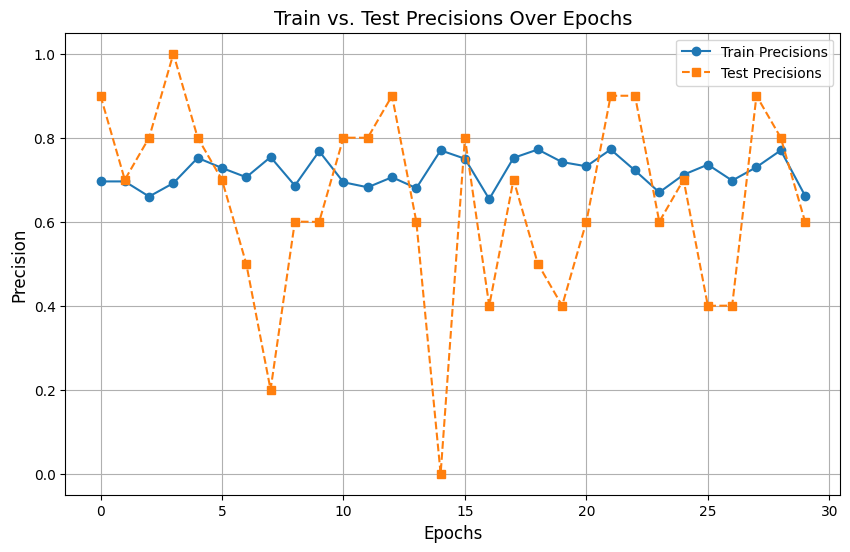

In [23]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_precisions, label='Train Precisions', marker='o', linestyle='-')
plt.plot(test_precisions, label='Test Precisions', marker='s', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Train vs. Test Precisions Over Epochs', fontsize=14)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()